# Application example: Using DIG on German Credit dataset

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from sklearn.metrics import f1_score, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix


import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, discrepancies_intervals, DIG_main, analysis_global

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

## Data and models preparation

We use the German Credit dataset (https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). 
The preprocessing steps applied to the data can be found in the ../discrepancies/datasets.py file. It includes rescaling and centering of the data, one-hot encoding categorical features and splitting the data into train and test.

For this example, a pool of basic models are trained on the training data. It includes classifiers such as Random Forest, SVM, Logistic Regression, XGBoost and Gradient Boosting. DIG is completely model agnostic, meaning that any classifier (no matter how many) can be added to the pool.

[15:32:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracies (F1):  {'SVMrbf': 0.8454935622317598, 'RF200': 0.8372093023255814, 'XGB': 0.8584269662921347, 'LR': 0.8487584650112867, 'GB': 0.841870824053452}
Discrepancies on train: 0.21142857142857144
Discrepancies on test: 0.24666666666666667


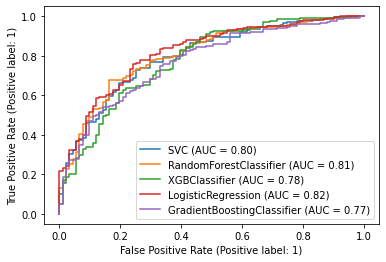

In [7]:
# Get data and fit a pool of classifiers on it 
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='german', test_size=0.3)
cont_names = list(set(feature_names) - set(cat_names))

pool1 = pool.BasicPool(models=["SVMrbf", "RF200", "LR", "XGB", "GB"])
pool1 = pool1.fit(X_train.values, y_train)

preds = pool1.predict(X_test)

print("Accuracies (F1): ", {c: f1_score(y_test, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(X_train).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(X_test).mean())

classifiers = [v for k, v in pool1.models.items()]#[pool1.models["SVMrbf"], pool1.models["RF200"]]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

# for i in classifiers:
#     plot_confusion_matrix(i, X_test, y_test, normalize='all')
#     plt.show()


## Fitting DIG

In this first step, DIG learns the discrepancies between the models from the pool. The output is an object (called 'pool2graph') which can be used to generate different types of explanations to understand where these discrepancies lie in the feature space. 

It takes as inputs: 
- the training data X_train and y_train (N.B. currently, X_train should be a pandas dataset, with feature names --> however, this can be easily modified in the code if needed)
- the pool object
- the list of the categorical features names, if relevant (otherwise, leave the parameter empty)

DIG parameters:
- k_init: The number of neighbors considered to explore the feature space. Local exploration parameter: the higher the more accurate it is, but the longer it takes.
- max_epochs: Number of iterations performed to refine the graph. The higher, the more precise the approximation is along the segments defined with k_init (but the longer it takes).

In [10]:
%%time 
disc_graph = DIG_main.pool2graph(X_train, y_train, pool1, k_init=10, categorical_names=cat_names)

disc_graph.fit(max_epochs=5)
intervals = discrepancies_intervals.get_discrepancies_intervals(disc_graph.G)

print(len(intervals))

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


CPU times: user 2min 3s, sys: 7.27 s, total: 2min 11s
Wall time: 1min 38s


## Extracting explanations from DIG

Preprocessing the graph

In [12]:
%% time
# extracting various information from the graph
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

Intervals amplitude dataset (self.amplitude_dataset): shape (14695, 63)
Input data preprocessed (self.X): shape (700, 64)
Discrepancy nodes dataset (self.nodes_dataset): shape (84505, 63)
Nodes dataset (self.nodes_dataset): shape (113671, 64)


### Contributions of each features to global discrepancy

Different ranking / importance for continuous and categorical features for now

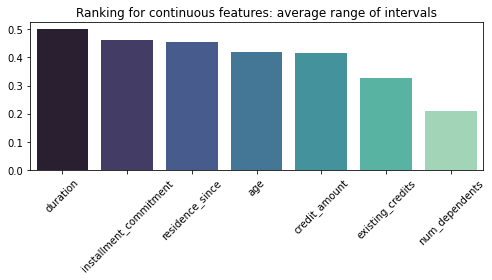

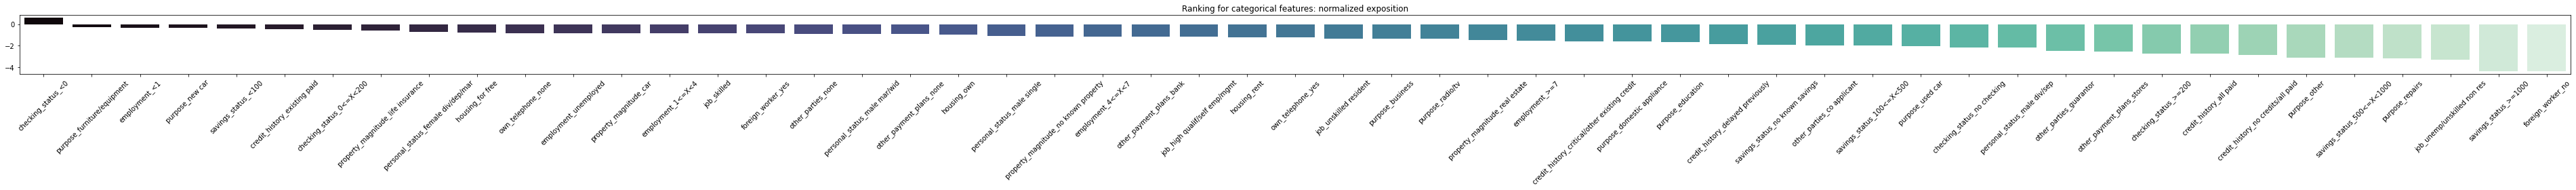

In [13]:
feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
gda.plot_feature_importances(palettes=['mako', 'mako'])#, savefig='')

In [91]:

print("AMPLITUDE DE DSICREPANCY CHAQUE FEATURE, MOYENNEE PAR INTERVALLE")
gda.amplitude_dataset.sum()[cont_names]/gda.amplitude_dataset.shape[0]

AMPLITUDE DE DSICREPANCY CHAQUE FEATURE, MOYENNEE PAR INTERVALLE


installment_commitment    0.462401
duration                  0.499705
existing_credits          0.326475
num_dependents            0.209277
credit_amount             0.414618
residence_since           0.454272
age                       0.417875
dtype: float64

In [97]:
gda.amplitude_dataset.groupby(cat_names).agg(['count', 'sum'])[cont_names]

MIN_COUNT = 200
m = gda.amplitude_dataset.groupby(cat_names).transform('count').ge(MIN_COUNT).iloc[:,0]
dm = gda.amplitude_dataset.loc[m]
print(dm.shape)
dm.groupby(cat_names).mean()[cont_names]




(722, 63)


installment_commitment  \
credit_history_no credits/all paid credit_history_all paid credit_history_existing paid credit_history_delayed previously credit_history_critical/other existing credit checking_status_<0 checking_status_0<=X<200 checking_status_>=200 checking_status_no checking purpose_new car purpose_used car purpose_furniture/equipment purpose_radio/tv purpose_domestic appliance purpose_repairs purpose_education purpose_vacation purpose_retraining purpose_business purpose_other savings_status_<100 savings_status_100<=X<500 savings_status_500<=X<1000 savings_status_>=1000 savings_status_no known savings employment_unemployed employment_<1 employment_1<=X<4 employment_4<=X<7 employment_>=7 personal_status_male div/sep personal_status_female div/dep/mar personal_status_male single personal_status_male mar/wid personal_status_female single other_parties_none other_parties_co applicant other_parties_guarantor property_magnitude_real estate property_magnitude_life insurance property_magnitude_car property_magnitude_no known property other_payment_plans_bank other_payment_plans_stores other_payment_plans_none housing_rent housing_own housing_for free job_unemp/unskilled non res job_unskilled resident job_skilled job_high qualif/self emp/mgmt own_telephone_none own_telephone_yes foreign_worker_yes foreign_worker_no                           
0                                  0                       0                            0                                 1                                             1                  0                        0                     0                           1               0                0                           0                0                          0               0                 0                0                  0                0             1                   0                         0                          0                     0                               0                     0             0                 0                 1              0                            0                                  1                           0                            0                             1                  0                          0                       0                              1                                 0                      0                                    0                        0                          1                        0            1           0                0                           0                      1           0                             1                  0                 1                  0                                0.114476   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       1                 0                 0              0                            0                                  1                           0                            0                             1                  0                          0                       0                              1                                 0                      0                                    0                        0                          1                        0            1           0                0                           0                      1           0                             1                  0                 1              

In [69]:
gda.amplitude_dataset.loc[m]

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,credit_history_no credits/all paid,credit_history_all paid,credit_history_existing paid,...,housing_own,housing_for free,job_unemp/unskilled non res,job_unskilled resident,job_skilled,job_high qualif/self emp/mgmt,own_telephone_none,own_telephone_yes,foreign_worker_yes,foreign_worker_no
1,0.063070,0.063199,0.111819,0.0,0.138951,0.107521,0.000000,0,0,1,...,1,0,0,0,1,0,1,0,1,0
2,0.000000,0.035377,0.111819,0.0,0.161183,0.107521,0.000000,0,0,1,...,1,0,0,0,1,0,1,0,1,0
3,0.000000,0.029969,0.111819,0.0,0.066696,0.000000,0.181687,0,0,1,...,1,0,0,0,1,0,1,0,1,0
4,0.057814,0.046552,0.000000,0.0,0.183415,0.107521,0.000000,0,0,1,...,1,0,0,0,1,0,1,0,1,0
5,0.000000,0.101228,0.223638,0.0,0.077812,0.000000,0.363374,0,0,1,...,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14690,0.000000,0.383363,0.670913,0.0,0.266785,0.645129,0.000000,0,1,0,...,1,0,0,0,0,1,0,1,1,0
14691,0.252280,0.824810,0.894551,0.0,0.489106,0.860172,1.453496,0,1,0,...,1,0,0,0,0,1,0,1,1,0
14692,0.630700,0.990816,0.000000,0.0,0.333482,1.075214,0.000000,0,1,0,...,1,0,0,0,0,1,0,1,1,0
14693,0.000000,0.072985,0.000000,0.0,0.050022,0.322564,0.545061,0,1,0,...,1,0,0,0,0,1,0,1,1,0


### Discrepancy segments

This function detects major discrepancy segments. Segments are defined by rules in the form of (FEATURE_i > THRESHOLD_i). Statistics are calculated over these segments: accuracy of models, size of the segment, purity of the segment...

The CART model used to detect these segments can be called with gda.segments_tree

Inputs:
- X_exposition: ground-truth data, e.g. X_train or X_test, used to justify the segments returned
- y_exposition: same

Parameters:
- min_expo: imposes segments to contain a minimum portion of exposition instances
- min_purity: filter on the purity (in terms of discrepancy) of the segments that are to be returned. Concretely, only the segments that contain a portion of min_purity of instances that have discrepancy will be returned.
- min_purity_expo: same but purity calculated on X_exposition instead of the nodes

In [16]:
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.05, min_purity=0.7, min_purity_expo=0.0)

Discrepancy segments tree accuracy on nodes: 0.6397996532460027
... on exposition data 0.47956403269754766
====== SEGMENT 16 ======
=== Segment description:
decision node 0 : checking_status_no checking <= 0.5)
decision node 1 : duration > 0.742146223783493)
decision node 15 : credit_amount <= 1.354268729686737)
=== Segment characteristics
Segment exposition: 0.06857142857142857
Segment node population (proxy for size?): 0.1403240331902318
Percent of the discrepancy nodes contained here: 0.21896471895545883
Segment purity: 0.7366814131721603
Segment purity (X_expo): 0.4166666666666667
Accuracy of classifiers (F1 on X_expo) on segment: {'SVMrbf': 0.7368421052631577, 'RF200': 0.8888888888888888, 'XGB': 0.9090909090909091, 'LR': 0.6938775510204082, 'GB': 0.8333333333333333}
Number of discrepancy segments found: 1


### Local Interval of Discrepancy

For one instance (any instance, assigned with discrepancy or not), returns an explanation about where the closest area of discrepancy is. This information takes the form of a "discrepancy interval", specifying for instance that there is a disagreement among models for "blond persons between 25 and 30 years old".




In [ ]:
import matplotlib as mpl
idx = 67
instance = X_test.iloc[idx]

fi = interval_relevant[cont_names]#fi[cont_names]
#fi = borders[1]
x = instance[cont_names]

mpl.style.use('default')
plt.viridis()

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(x=range(len(x)), height=normalize(fi.max())-normalize(fi.min()), bottom=normalize(fi.min())-normalize(x))

plt.hlines(0, -0.5, len(cont_names), color='r')

for i in range(len(x)):
    y1 = normalize(fi.max()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y1+0.03, str(fi.max().round(2).iloc[i]))

for i in range(len(x)):
    y2 = normalize(fi.min()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y2-0.04, str(fi.min().round(2).iloc[i]))

for i in range(len(x)):
    y2 = -0.5
    ax.text(i-0.45, y2-0.04, str(x.round(2).iloc[i]), c='r')

gar = ax.set_ylim((-0.55,1.2))
gar = ax.set(yticklabels=[])
gar = ax.tick_params(left=False)
gar = plt.xticks(np.arange(len(x)), list(x.index), rotation=90)

<Figure size 640x480 with 0 Axes>

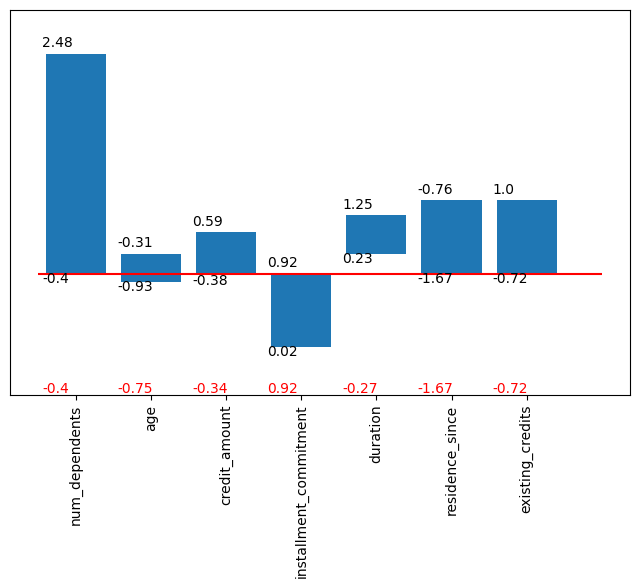